In [0]:
# !wget http://www.brucehardie.com/datasets/1995_cohort_binary.zip
# !unzip 1995_cohort_binary.zip

### Load Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoBetaBinomFitter

### Load Data

In [0]:
transaction_opportunity = list(range(1995,2007,1))
columns = ['supporter_id']+transaction_opportunity
raw_data = pd.read_csv('1995_cohort_binary.txt',sep=' ',header=None,encoding='utf-8',names=columns)
raw_data.head()

,supporter_id,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,100001,1,0,0,0,0,0,0,0,0,0,0,0
1,100002,1,0,0,0,0,0,0,0,1,1,1,1
2,100003,1,0,0,0,0,0,0,0,0,0,0,0
3,100004,1,0,1,0,1,1,1,1,1,1,1,0
4,100005,1,0,1,1,1,0,1,1,1,1,1,1


In [0]:
raw_data.shape

(11104, 13)

### Train & Test Data Split. Last 5 year transaction opportunity is used for Test purpose

In [0]:
train_tx = transaction_opportunity[:-5]
test_tx = transaction_opportunity[-5::]

In [0]:
raw_data['train_freq'] = raw_data[train_tx].sum(axis=1)-1
raw_data.loc[raw_data['train_freq']<0, 'train_freq'] = 0

raw_data['test_freq'] = raw_data[test_tx].sum(axis=1)
# raw_data.loc[raw_data['test_freq']<0, 'test_freq'] = 0

raw_data.sample(5)

,supporter_id,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,train_freq,test_freq
5222,105223,1,0,0,0,0,0,0,0,0,1,1,0,0,2
1306,101307,1,0,0,1,0,0,0,0,0,0,0,0,1,0
10387,110388,1,1,0,1,1,1,1,0,0,0,0,0,5,0
7589,107590,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4118,104119,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Get First & Last Transaction by supporter

In [0]:
def get_first_tx(row,train_tx):
    idx = row.loc[train_tx]
    tx = idx[row.loc[train_tx] == 1]
    first_tx = tx.index[0]
    last_tx = tx.index[-1]
    return [first_tx,last_tx]

In [0]:
raw_data['first_tx'], raw_data['last_tx'] = zip(*raw_data.apply(get_first_tx,axis=1,train_tx=train_tx))
raw_data.head()

,supporter_id,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,train_freq,test_freq,first_tx,last_tx
0,100001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,1995
1,100002,1,0,0,0,0,0,0,0,1,1,1,1,0,4,1995,1995
2,100003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,1995
3,100004,1,0,1,0,1,1,1,1,1,1,1,0,4,4,1995,2001
4,100005,1,0,1,1,1,0,1,1,1,1,1,1,4,5,1995,2001


### Compute Recency, Frequency, Age and Weights

In [0]:
raw_data['period'] = train_tx[-1] - raw_data['first_tx']
raw_data['recency'] = raw_data['last_tx'] - raw_data['first_tx']
raw_data.head()

,supporter_id,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,train_freq,test_freq,first_tx,last_tx,period,recency
0,100001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,1995,6,0
1,100002,1,0,0,0,0,0,0,0,1,1,1,1,0,4,1995,1995,6,0
2,100003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,1995,6,0
3,100004,1,0,1,0,1,1,1,1,1,1,1,0,4,4,1995,2001,6,6
4,100005,1,0,1,1,1,0,1,1,1,1,1,1,4,5,1995,2001,6,6


In [0]:
rfm_data = raw_data[['supporter_id','train_freq','recency','period','test_freq']].copy()
rfm_data.head()

,supporter_id,train_freq,recency,period,test_freq
0,100001,0,0,6,0
1,100002,0,0,6,4
2,100003,0,0,6,0
3,100004,4,6,6,4
4,100005,4,6,6,5


In [0]:
weights = rfm_data.groupby(['train_freq','recency']).size().reset_index()
weights.rename({0:'weights'},axis=1,inplace=True)
rfm_data = rfm_data.merge(weights, on=['train_freq','recency'],how='left')
rfm_data.set_index('supporter_id',inplace=True)
rfm_data.head()

,train_freq,recency,period,test_freq,weights
supporter_id,,,,,
100001,0,0,6,0,3464
100002,0,0,6,4,3464
100003,0,0,6,0,3464
100004,4,6,6,4,512
100005,4,6,6,5,512


### Fit BG/BB Model

In [0]:
model = BetaGeoBetaBinomFitter(penalizer_coef=0.0)
model.fit(rfm_data['train_freq'],rfm_data['recency'],rfm_data['period'],weights=rfm_data['weights'],index=rfm_data.index)

<lifetimes.BetaGeoBetaBinomFitter: fitted with 11104 subjects, alpha: 2.49, beta: 0.51, delta: 0.13, gamma: 0.30>

### Predict Transaction in Next 5 period i.e. Transaction opportunity

In [0]:
rfm_data['test_tx_predict']= model.conditional_expected_number_of_purchases_up_to_time(m_periods_in_future=len(test_tx),
                                                                                        frequency=rfm_data['train_freq'],
                                                                                        recency=rfm_data['recency'],
                                                                                        n_periods = rfm_data['period']) 

rfm_data.sample(10,random_state=98)

,train_freq,recency,period,test_freq,weights,test_tx_predict
supporter_id,,,,,,
108311,6,6,6,5,1203,4.178225
101027,1,1,6,0,1091,0.018858
104111,0,0,6,0,3464,0.002320
106685,0,0,6,0,3464,0.002320
107554,0,0,6,0,3464,0.002320
106411,5,6,6,3,728,3.685950
107458,3,3,6,0,322,0.126129
109356,1,5,6,0,119,1.554148
101644,0,0,6,0,3464,0.002320


### Actual Test Cumulative Transaction vs Predicted Test Cumulative Transaction

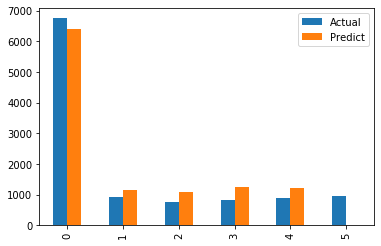

In [0]:
predict = rfm_data['test_tx_predict'].astype(int).value_counts()
actual =  rfm_data['test_freq'].astype(int).value_counts()
pd.DataFrame({'Actual':actual,'Predict':predict}).plot(kind='bar')

### Compute Alive Probability for Next Transaction Opportunity

In [0]:
rfm_data['alive_prob_next_tx'] = model.conditional_probability_alive(m_periods_in_future=1,
                                                                                        frequency=rfm_data['train_freq'],
                                                                                        recency=rfm_data['recency'],
                                                                                        n_periods = rfm_data['period']) 
rfm_data.sample(5,random_state=9)

,train_freq,recency,period,test_freq,weights,test_tx_predict,alive_prob_next_tx
supporter_id,,,,,,,
104128,1,3,6,0,129,0.743656,0.412760
110378,6,6,6,0,1203,4.178225,0.952924
104035,2,6,6,4,234,2.209124,0.952924
105964,0,0,6,0,3464,0.002320,0.001806
107615,3,4,6,0,181,1.157121,0.408177


### Find Best future customers based on Predicted Transaction

In [0]:
rfm_data.sort_values(by=['test_tx_predict'],ascending=False).head(10)

,train_freq,recency,period,test_freq,weights,test_tx_predict,alive_prob_next_tx
supporter_id,,,,,,,
103579,6,6,6,4,1203,4.178225,0.952924
105386,6,6,6,3,1203,4.178225,0.952924
107758,6,6,6,5,1203,4.178225,0.952924
104301,6,6,6,3,1203,4.178225,0.952924
110364,6,6,6,3,1203,4.178225,0.952924
104303,6,6,6,3,1203,4.178225,0.952924
106387,6,6,6,2,1203,4.178225,0.952924
101202,6,6,6,2,1203,4.178225,0.952924
110362,6,6,6,4,1203,4.178225,0.952924
